# Import Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

# Import Classifiers & Packages for Modeling

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
sns.set(style="darkgrid")

## Helper Functions

In [6]:
# Returns dataframe of accuracy, precision, recall, and f1 score for training and testing data
def get_metrics(train_pred, test_pred):
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)

    train_precision = precision_score(y_train, train_pred)
    test_precision = precision_score(y_test, test_pred)

    train_recall = recall_score(y_train, train_pred)
    test_recall = recall_score(y_test, test_pred)

    train_f1 = f1_score(y_train, train_pred, average='weighted')
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    
    train_metrics = [round(train_accuracy * 100, 3), round(train_precision, 3), 
                     round(train_recall, 3), round(train_f1, 3)]
    test_metrics = [round(test_accuracy * 100, 3), round(test_precision, 3), 
                    round(test_recall, 3), round(test_f1, 3)]
    
    metrics = pd.DataFrame([train_metrics, test_metrics])
    metrics.index = ['Training Data', 'Testing Data']
    metrics.columns = ['Accuracy (%)', 'Precision', 'Recall', 'F1 Score']
    
    return metrics

# Load Data

In [7]:
ipeds_data = pd.read_csv('~/Desktop/Flatiron/Projects/Mod5_20191213/ipeds_new_data.csv')
ipeds_data.drop('Unnamed: 0', axis = 1, inplace = True)
ipeds_data.head()

,unitid,inst_name,state_abbr,region,urban_centric_locale,title_iv_indicator,inst_control,institution_level,inst_category,inst_size,...,cb_region,headcount_asn_Total_prop,headcount_blk_Total_prop,headcount_hsp_Total_prop,headcount_hwnpi_Total_prop,headcount_mlt_Total_prop,headcount_nonres_Total_prop,headcount_ntv_Total_prop,headcount_unknown_Total_prop,headcount_wht_Total_prop
0,102553.0,University of Alaska Anchorage,AK,8.0,11.0,1.0,1.0,4.0,2.0,4.0,...,West,0.060485,0.030683,0.070895,0.006632,0.086845,0.015237,0.064473,0.072448,0.592302
1,102614.0,University of Alaska Fairbanks,AK,8.0,23.0,1.0,1.0,4.0,2.0,3.0,...,West,0.018203,0.022080,0.054947,0.008680,0.052419,0.011377,0.200067,0.181864,0.450362
2,102632.0,University of Alaska Southeast,AK,8.0,33.0,1.0,1.0,4.0,2.0,2.0,...,West,0.035880,0.011100,0.055756,0.007486,0.070986,0.009293,0.119773,0.156686,0.533041
3,102845.0,Charter College,WA,8.0,12.0,1.0,3.0,4.0,3.0,2.0,...,West,0.002653,0.062776,0.269231,0.055040,0.049735,0.000000,0.101459,0.055261,0.403846
4,103945.0,CollegeAmerica-Flagstaff,AZ,6.0,13.0,1.0,2.0,4.0,3.0,1.0,...,West,0.000000,0.022059,0.058824,0.007353,0.132353,0.000000,0.558824,0.000000,0.220588


In [8]:
ipeds_data.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'title_iv_indicator', 'inst_control',
       'institution_level', 'inst_category', 'inst_size', 'sector',
       'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_enroll_2015', 'cc_size_setting_2015', 'inst_affiliation',
       'occupational_prog_offered', 'academic_prog_offered',
       'avocational_prog_offered', 'remedial_prog_offered',
       'secondary_prog_offered', 'assoc_offered', 'bach_offered',
       'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'remedial_services',
       'academic_counseling', 'employment_services', 'placement_services',
       'oncampus_daycare', 'oncampus_housing', 'oncampus_required',
       'meal_plan', 'tuition_vari

# Make Dummy Variables

In [9]:
dummy_vars = ['institution_level', 'inst_control', 'inst_category', 'inst_size', 
              'tuition_varies', 'study_abroad', 'yellow_ribbon_program', 
              'weekend_evening_college', 'oncampus_housing', 'rotc']
# added more contiuous variables about race proportions
cont_vars = ['headcount_blk_Total_prop', 'headcount_hsp_Total_prop', 
             'headcount_wht_Total_prop', 'headcount_hwnpi_Total_prop', 
             'headcount_ntv_Total_prop', 'headcount_asn_Total_prop', 
             'lowincome_pct', 'fafsa_sent_2ormore_pct', 
             'independent_pct', 'first_gen_student_pct', 'faminc_mean']

In [10]:
dummies = ipeds_data[dummy_vars].astype('str')
cont = ipeds_data[cont_vars]
X = pd.get_dummies(pd.concat([dummies, cont], axis = 1), drop_first = True)
y = ipeds_data['cb_region'].replace({'Northeast': 0, 'West': 1})

# Train, Test, Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

# UNSCALED MODELS

# Baseline Model: Dummy Classifier (F1 = 0.45)

In [12]:
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train, y_train)
dummy_y_train_pred = dummy_clf.predict(X_train)
dummy_y_test_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_y_test_pred))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       174
           1       0.44      0.44      0.44       165

    accuracy                           0.45       339
   macro avg       0.45      0.45      0.45       339
weighted avg       0.45      0.45      0.45       339



In [13]:
get_metrics(dummy_y_train_pred, dummy_y_test_pred)

,Accuracy (%),Precision,Recall,F1 Score
Training Data,52.152,0.525,0.523,0.522
Testing Data,45.428,0.440,0.442,0.454


# K-Nearest Neighbors (n = 1) (F1 = 0.58)

In [14]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scale = scaler.transform(X_train)  
X_test_scale = scaler.transform(X_test)  

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_scale, y_train)

knn_y_train_pred = model.predict(X_train_scale)
knn_y_test_pred = model.predict(X_test_scale)

In [15]:
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score(y_test, knn_y_test_pred, average='weighted')

0.7846982482258335

In [16]:
cm = confusion_matrix(y_test, knn_y_test_pred)
regions = ['Northeast', 'West']

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.21
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[135  39]
 [ 34 131]]


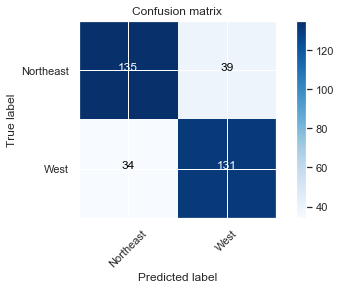

In [18]:
import itertools
plot_confusion_matrix(cm, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [19]:
print(classification_report(y_test, knn_y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       174
           1       0.77      0.79      0.78       165

    accuracy                           0.78       339
   macro avg       0.78      0.78      0.78       339
weighted avg       0.79      0.78      0.78       339



In [20]:
# Accuracy of training and test sets
get_metrics(knn_y_train_pred, knn_y_test_pred)

,Accuracy (%),Precision,Recall,F1 Score
Training Data,100.000,1.000,1.000,1.000
Testing Data,78.466,0.771,0.794,0.785


## Optimize k for KNN

In [21]:
# search for an optimal value of K for KNN
k_range = list(range(1, 25))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scale, y_train)
    y_predict = knn.predict(X_test_scale)
    score = f1_score(y_test, y_predict, average='weighted')
    k_scores.append( score)
pd.DataFrame(list(zip(k_range, k_scores)), columns = ['k', 'scores']).sort_values(by = 'scores', 
                                                                                  ascending = False).head()

,k,scores
2,3,0.802394
4,5,0.787648
0,1,0.784698
1,2,0.775083
5,6,0.774671


## K-Nearest Neighbors (k = 3) (F1 = 0.80)

In [22]:
knn_opt = KNeighborsClassifier(n_neighbors=3)
knn_opt.fit(X_train_scale, y_train)

knn_opt_y_train_pred = knn_opt.predict(X_train_scale)
knn_opt_y_test_pred = knn_opt.predict(X_test_scale)

In [23]:
f1_score(y_test, knn_opt_y_test_pred, average='weighted')

0.8023942826182306

Confusion Matrix, without normalization
[[138  36]
 [ 31 134]]


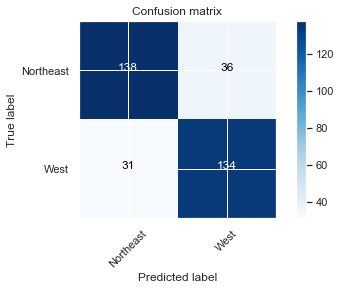

In [24]:
cm_opt = confusion_matrix(y_test, knn_opt_y_test_pred)
plot_confusion_matrix(cm_opt, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [25]:
print(classification_report(y_test, knn_opt_y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       174
           1       0.79      0.81      0.80       165

    accuracy                           0.80       339
   macro avg       0.80      0.80      0.80       339
weighted avg       0.80      0.80      0.80       339



In [26]:
# Accuracy of training and test sets
get_metrics(knn_opt_y_train_pred, knn_opt_y_test_pred)

,Accuracy (%),Precision,Recall,F1 Score
Training Data,90.506,0.903,0.910,0.905
Testing Data,80.236,0.788,0.812,0.802


# Decision Tree (max_depth = 2) (F1 = 0.78)

In [27]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth = 2, random_state = 42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [28]:
dtree_y_train_pred = dtree.predict(X_train)
dtree_y_test_pred = dtree.predict(X_test)

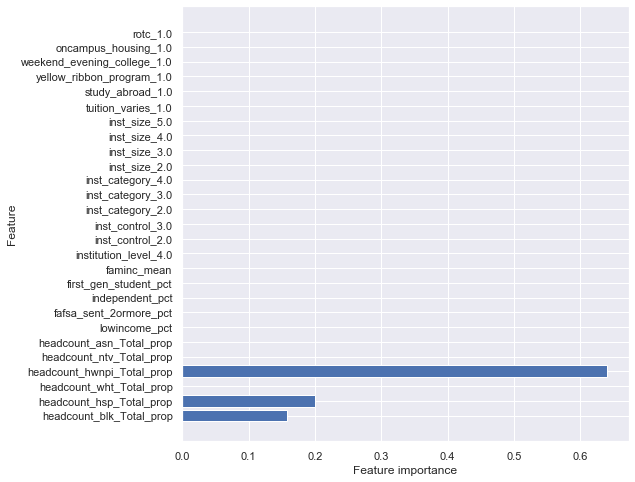

In [29]:
import numpy as np
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dtree.fit(X_train, y_train))

In [30]:
print(accuracy_score(y_test, dtree_y_test_pred))
print(f1_score(y_test, dtree_y_test_pred, average='weighted'))

0.7817109144542773
0.7811668657364677


Confusion Matrix, without normalization
[[126  48]
 [ 26 139]]


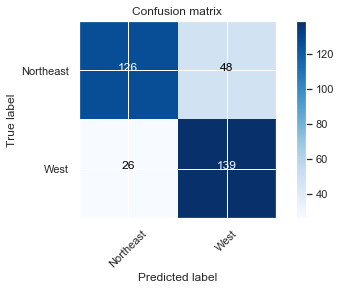

In [31]:
cm_tree = confusion_matrix(y_test, dtree_y_test_pred)
plot_confusion_matrix(cm_tree, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [32]:
print(classification_report(y_test, dtree_y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       174
           1       0.74      0.84      0.79       165

    accuracy                           0.78       339
   macro avg       0.79      0.78      0.78       339
weighted avg       0.79      0.78      0.78       339



In [33]:
get_metrics(dtree_y_train_pred, dtree_y_test_pred)

,Accuracy (%),Precision,Recall,F1 Score
Training Data,82.658,0.774,0.927,0.825
Testing Data,78.171,0.743,0.842,0.781


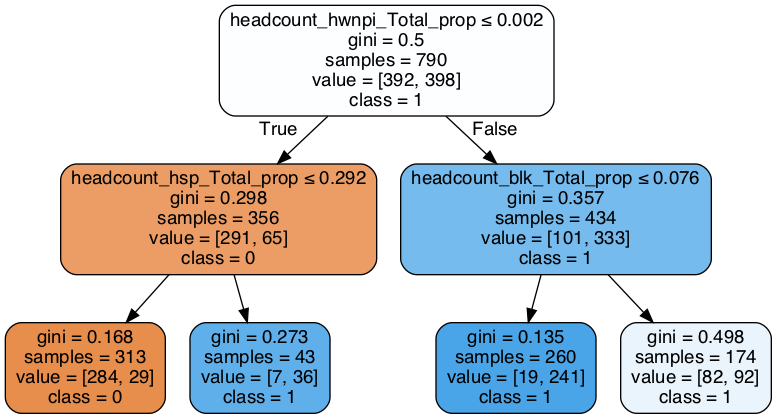

In [34]:
# Create DOT data
dot_data = export_graphviz(dtree, out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Tune Max_Depth

[0.768209794397498, 0.7716536917515027, 0.8326651806507419, 0.8478278106771352, 0.8628882771087009, 0.8788335606715905, 0.8761240767848826, 0.8814806651584715, 0.870884068578526]


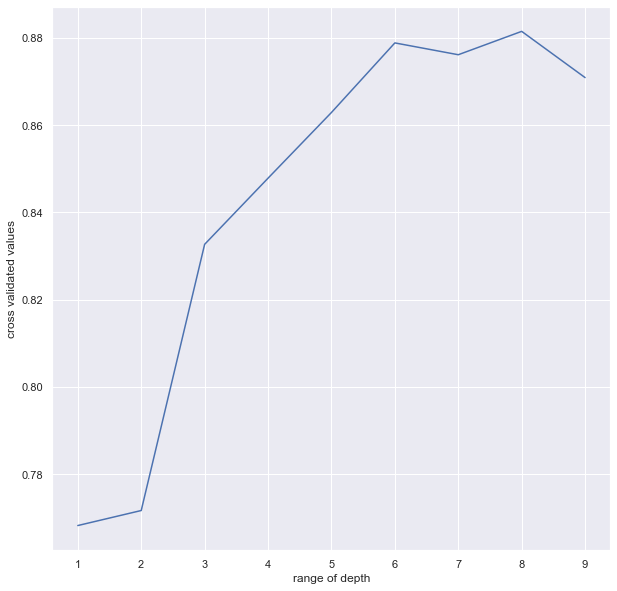

In [35]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(dtree, X, y, cv = 10)
score.mean()
depth_range = range(1,10)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    depth_score = cross_val_score(ctree, X, y, cv = 10)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

In [36]:
dtree_max_depth = pd.DataFrame(zip(depth_range, val))
dtree_max_depth.columns = ['max_depth', 'mean_score']
dtree_max_depth.sort_values(by = 'mean_score', ascending = False).head()

,max_depth,mean_score
7,8,0.881481
5,6,0.878834
6,7,0.876124
8,9,0.870884
4,5,0.862888


## Decision Tree (max_depth = 8) (F1 = 0.88)

In [37]:
dtree8 = DecisionTreeClassifier(max_depth = 8, random_state = 42)
dtree8.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [38]:
dtree8_y_train_pred = dtree8.predict(X_train)
dtree8_y_test_pred = dtree8.predict(X_test)

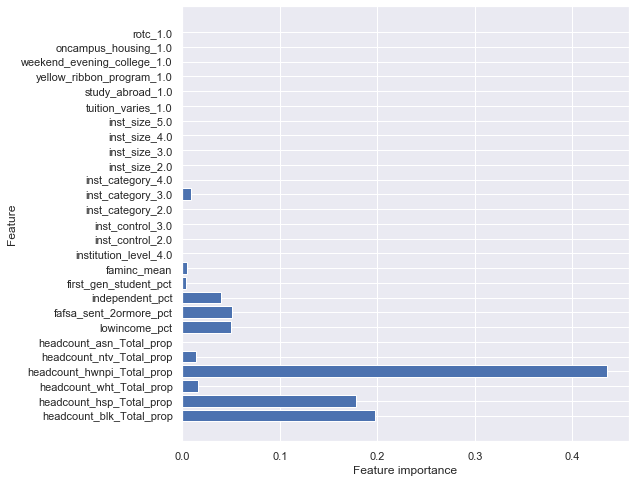

In [39]:
plot_feature_importances(dtree8.fit(X_train, y_train))

In [40]:
print(accuracy_score(y_test, dtree8_y_test_pred))
print(f1_score(y_test, dtree8_y_test_pred, average='weighted'))

0.8761061946902655
0.8760500520707373


Confusion Matrix, without normalization
[[155  19]
 [ 23 142]]


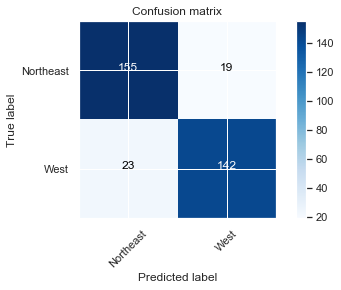

In [41]:
cm_tree = confusion_matrix(y_test, dtree8_y_test_pred)
plot_confusion_matrix(cm_tree, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [42]:
print(classification_report(y_test, dtree8_y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       174
           1       0.88      0.86      0.87       165

    accuracy                           0.88       339
   macro avg       0.88      0.88      0.88       339
weighted avg       0.88      0.88      0.88       339



In [43]:
get_metrics(dtree8_y_train_pred, dtree8_y_test_pred)

,Accuracy (%),Precision,Recall,F1 Score
Training Data,98.734,0.983,0.992,0.987
Testing Data,87.611,0.882,0.861,0.876


## Tune Model Using GridSearchCV

In [44]:
clf = DecisionTreeClassifier(random_state = 42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20], 
    
}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

## Decision Tree (max_depth = 10, min_samples_split = 2) (F1 = 0.88)

In [45]:
dtree_opt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, 
                                   min_samples_split = 2, random_state = 42)
dtree_opt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [46]:
dtree_opt_y_train_pred = dtree_opt.predict(X_train)
dtree_opt_y_test_pred = dtree_opt.predict(X_test)

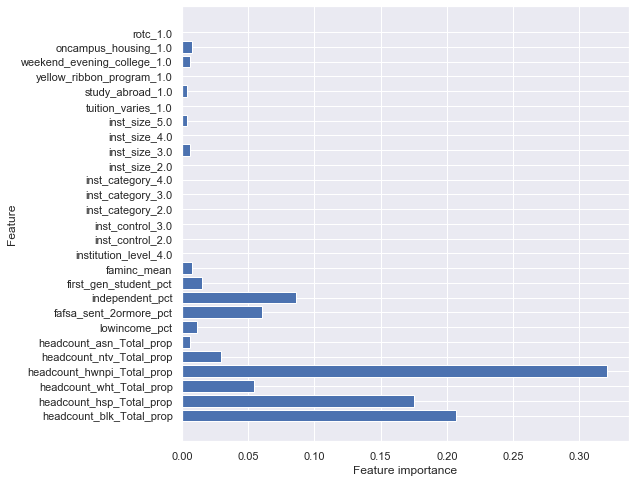

In [47]:
plot_feature_importances(dtree_opt.fit(X_train, y_train))

In [48]:
print(accuracy_score(y_test, dtree_opt_y_test_pred))
print(f1_score(y_test, dtree_opt_y_test_pred, average='weighted'))

0.8761061946902655
0.8760089773289115


Confusion Matrix, without normalization
[[156  18]
 [ 24 141]]


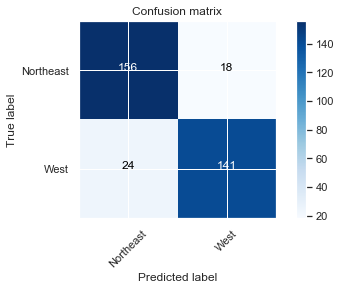

In [49]:
cm_tree = confusion_matrix(y_test, dtree_opt_y_test_pred)
plot_confusion_matrix(cm_tree, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [50]:
print(classification_report(y_test, dtree_opt_y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       174
           1       0.89      0.85      0.87       165

    accuracy                           0.88       339
   macro avg       0.88      0.88      0.88       339
weighted avg       0.88      0.88      0.88       339



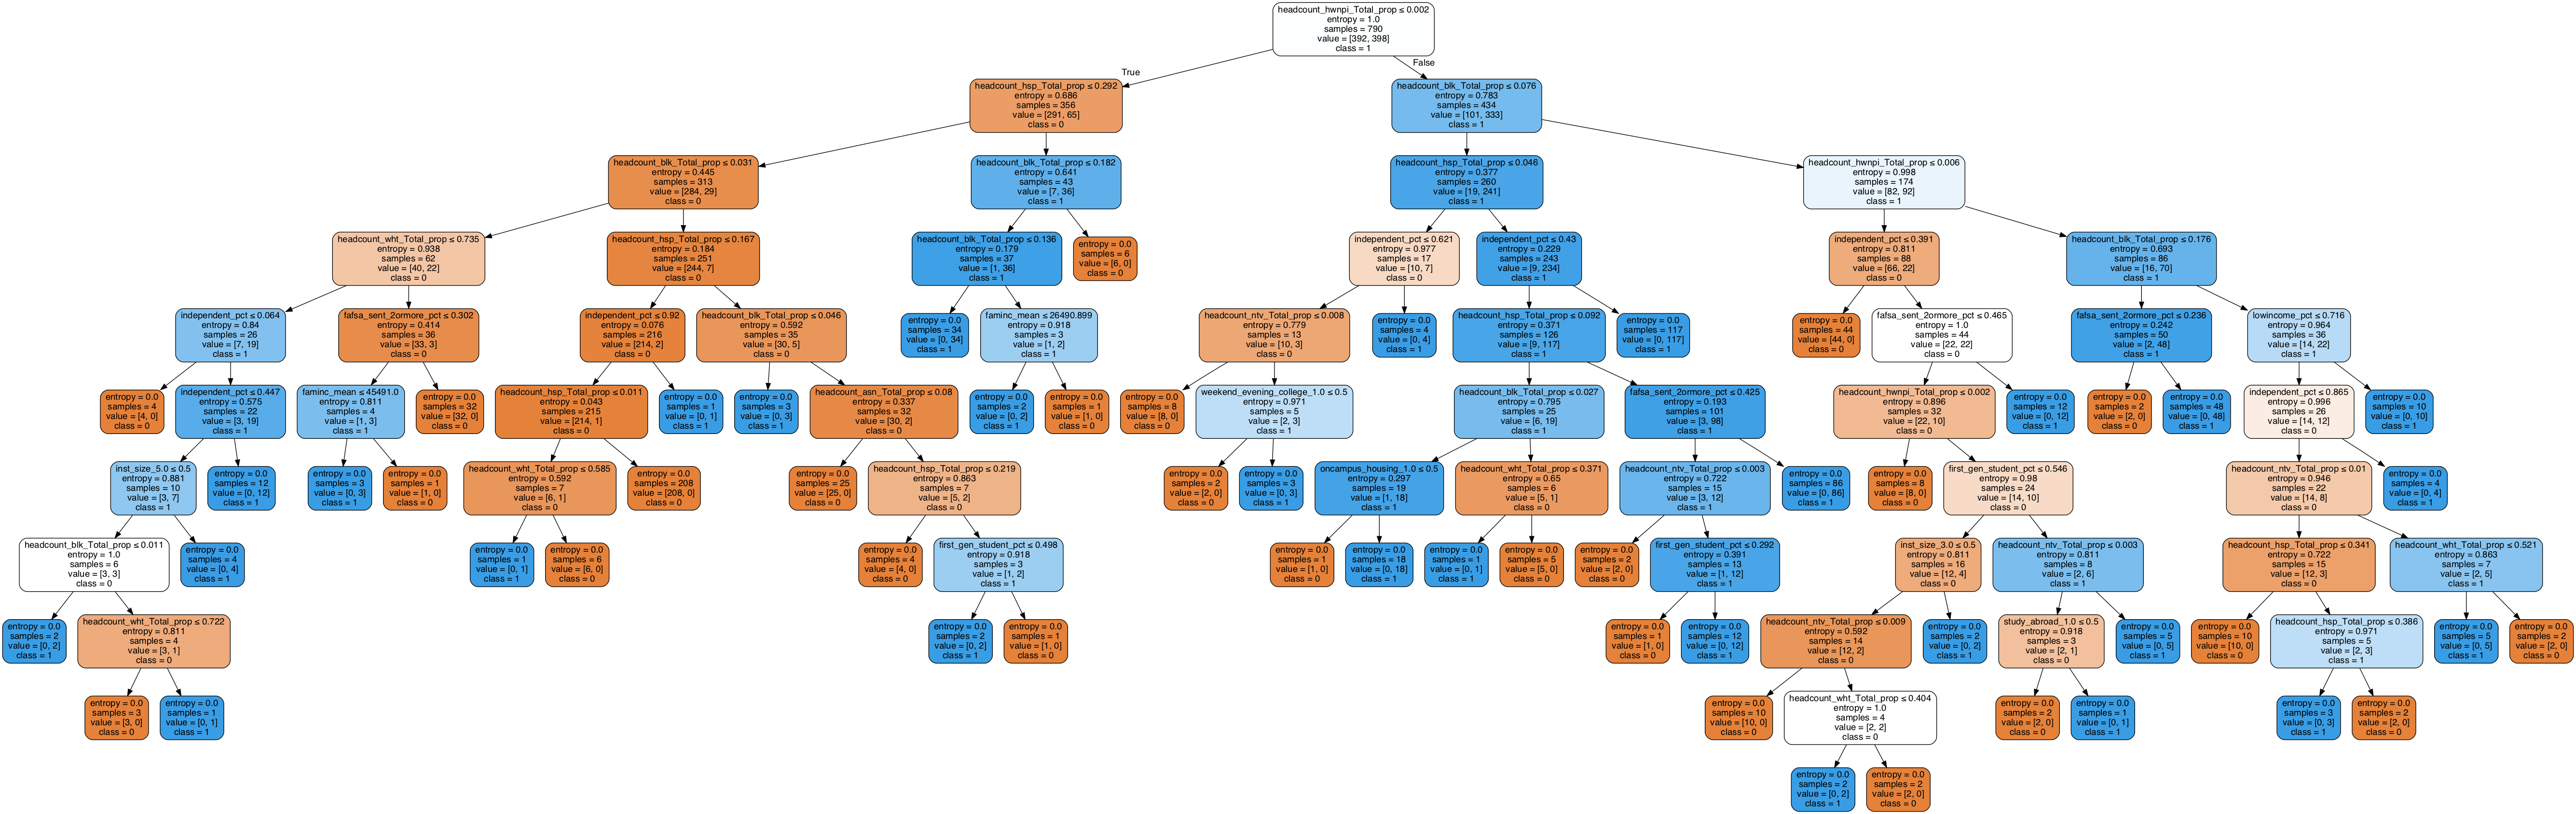

In [51]:
# Create DOT data
dot_data = export_graphviz(dtree_opt, out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [52]:
get_metrics(dtree_opt_y_train_pred, dtree_opt_y_test_pred)

,Accuracy (%),Precision,Recall,F1 Score
Training Data,100.000,1.000,1.000,1.000
Testing Data,87.611,0.887,0.855,0.876


# Random Forest (n_est = 100, max_depth = 2) (F1 = 0.82)

In [53]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)

Confusion Matrix, without normalization
[[132  42]
 [ 19 146]]


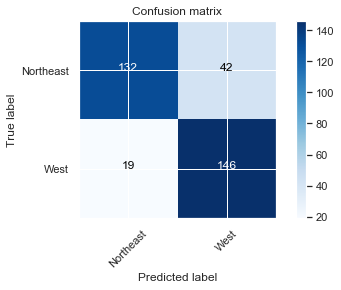

In [55]:
cm_forest = confusion_matrix(y_test, forest_test_pred)
plot_confusion_matrix(cm_forest, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [56]:
print(classification_report(y_test, forest_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       174
           1       0.78      0.88      0.83       165

    accuracy                           0.82       339
   macro avg       0.83      0.82      0.82       339
weighted avg       0.83      0.82      0.82       339



In [57]:
get_metrics(forest_train_pred, forest_test_pred)

,Accuracy (%),Precision,Recall,F1 Score
Training Data,86.456,0.826,0.927,0.864
Testing Data,82.006,0.777,0.885,0.820


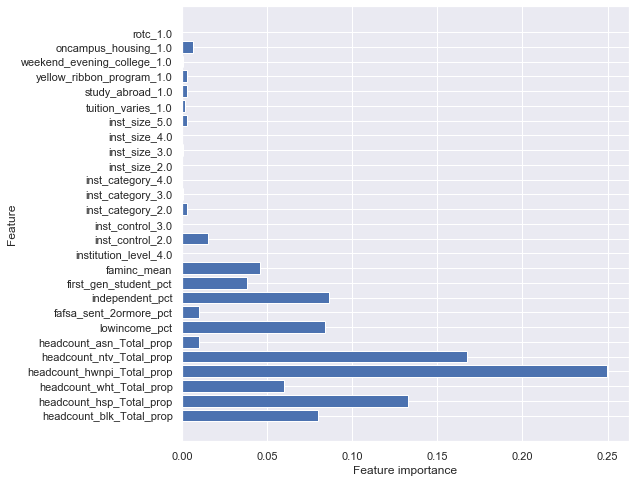

In [58]:
plot_feature_importances(forest.fit(X_train, y_train))

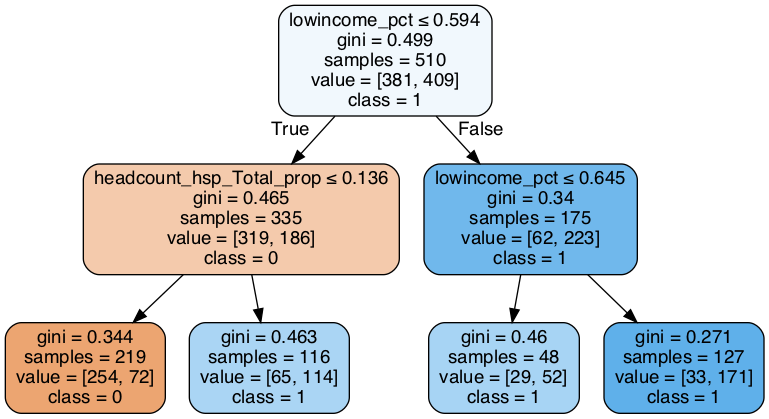

In [59]:
# Create DOT data
dot_data = export_graphviz(forest.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Optimize Random Forest Using GridSearchCV

In [ ]:
forest_base = RandomForestClassifier(random_state = 42)

param_grid = {
    'n_estimators': [50, 100, 125, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20]
}

gs_tree = GridSearchCV(forest_base, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

## Random Forest (n_estimators = 125, max_depth = 10, min_samples_split = 5) (F1 = 0.93)

In [ ]:
forest_opt = RandomForestClassifier(criterion = 'entropy', n_estimators = 125, 
                                    max_depth = 10, min_samples_split = 5, 
                                    random_state = 42)
forest_opt.fit(X_train, y_train)

In [ ]:
forest_opt_train_pred = forest_opt.predict(X_train)
forest_opt_test_pred = forest_opt.predict(X_test)

In [ ]:
cm_forest_opt = confusion_matrix(y_test, forest_opt_test_pred)
plot_confusion_matrix(cm_forest_opt, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
print(classification_report(y_test, forest_opt_test_pred))

In [ ]:
plot_feature_importances(forest_opt.fit(X_train, y_train))

In [ ]:
# Create DOT data
dot_data = export_graphviz(forest_opt.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True, 
                           max_depth = 4)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [ ]:
get_metrics(forest_opt_train_pred, forest_opt_test_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Scikit-learn's built in roc_curve method returns the fpr, tpr, and thresholds
# for various decision boundaries given the case member probabilites

# First calculate the probability scores of each of the datapoints:
y_score = forest_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# AdaBoost (n_estimators = 100) (F1 = 0.91)

In [ ]:
ab_clf = AdaBoostClassifier(n_estimators = 100, random_state = 42)

In [ ]:
ab_clf.fit(X_train, y_train)
ab_train_pred = ab_clf.predict(X_train)
ab_test_pred = ab_clf.predict(X_test)

In [ ]:
cm_ab = confusion_matrix(y_test, ab_test_pred)
plot_confusion_matrix(cm_ab, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
print(classification_report(y_test, ab_test_pred))

In [ ]:
plot_feature_importances(ab_clf.fit(X_train, y_train))

In [ ]:
get_metrics(ab_train_pred, ab_test_pred)

## Optimize AdaBoost for n_estimators

In [ ]:
n_est = [25, 50, 100, 125, 150, 175, 200]
val = []
for n in n_est:
    ab_clf = AdaBoostClassifier(n_estimators = n, random_state = 42)
    n_score = cross_val_score(ab_clf, X, y, cv = 10)
    val.append(n_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(n_est, val)
plt.xlabel('number of estimators')
plt.ylabel('cross validated values')
plt.show()

## AdaBoost (n_estimators = 175) (F1 = 0.91)

In [ ]:
ab_clf_opt = AdaBoostClassifier(n_estimators = 175, random_state = 42)

In [ ]:
ab_clf_opt.fit(X_train, y_train)
ab_opt_train_pred = ab_clf_opt.predict(X_train)
ab_opt_test_pred = ab_clf_opt.predict(X_test)

In [ ]:
cm_ab_opt = confusion_matrix(y_test, ab_opt_test_pred)
plot_confusion_matrix(cm_ab_opt, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
print(classification_report(y_test, ab_opt_test_pred))

In [ ]:
plot_feature_importances(ab_clf_opt.fit(X_train, y_train))

In [ ]:
get_metrics(ab_opt_train_pred, ab_opt_test_pred)

# XGBoost

In [ ]:
# Instantiate XGBClassifier
xgb = XGBClassifier(random_state = 42)

# Fit XGBClassifier
xgb.fit(X_train, y_train)

# Predict on training and test sets
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)

get_metrics(xgb_train_pred, xgb_test_pred)

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 8],
    'min_child_weight': [1],
    'subsample': [0.5],
    'n_estimators': [100, 125],
}

In [ ]:
grid_clf = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

xgb_opt_train_pred = grid_clf.predict(X_train)
xgb_opt_test_pred = grid_clf.predict(X_test)

get_metrics(xgb_opt_train_pred, xgb_opt_test_pred)

# COMPARING MODELS!

In [ ]:
dummy_metrics = get_metrics(dummy_y_train_pred, dummy_y_test_pred)
dummy_metrics.index = ['Baseline Training', 'Baseline Testing']
dummy_metrics['Model'] = ['Baseline', 'Baseline']
dummy_metrics['Data'] = ['Training', 'Testing']

knn_metrics = get_metrics(knn_y_train_pred, knn_y_test_pred)
knn_metrics.index = ['KNN Training', 'KNN Testing']
knn_metrics['Model'] = ['KNN', 'KNN']
knn_metrics['Data'] = ['Training', 'Testing']

knn_opt_metrics = get_metrics(knn_opt_y_train_pred, knn_opt_y_test_pred)
knn_opt_metrics.index = ['KNN Opt. Training', 'KNN Opt. Testing']
knn_opt_metrics['Model'] = ['KNN Opt.', 'KNN Opt.']
knn_opt_metrics['Data'] = ['Training', 'Testing']

dtree_metrics = get_metrics(dtree_y_train_pred, dtree_y_test_pred)
dtree_metrics.index = ['Decision Tree Training', 'Decision Tree Testing']
dtree_metrics['Model'] = ['Decision Tree', 'Decision Tree']
dtree_metrics['Data'] = ['Training', 'Testing']

dtree8_metrics = get_metrics(dtree8_y_train_pred, dtree8_y_test_pred)
dtree8_metrics.index = ['Decision Tree (Max. Depth 8) Training', 
                        'Decision Tree (Max. Depth 8) Testing']
dtree8_metrics['Model'] = ['Decision Tree (Max. Depth 8)', 'Decision Tree (Max. Depth 8)']
dtree8_metrics['Data'] = ['Training', 'Testing']

dtree_opt_metrics = get_metrics(dtree_opt_y_train_pred, dtree_opt_y_test_pred)
dtree_opt_metrics.index = ['Decision Tree Opt. Training', 'Decision Tree Opt. Testing']
dtree_opt_metrics['Model'] = ['Decision Tree Opt.', 'Decision Tree Opt.']
dtree_opt_metrics['Data'] = ['Training', 'Testing']

forest_metrics = get_metrics(forest_train_pred, forest_test_pred)
forest_metrics.index = ['Random Forest Training', 'Random Forest Testing']
forest_metrics['Model'] = ['Random Forest', 'Random Forest']
forest_metrics['Data'] = ['Training', 'Testing']

forest_opt_metrics = get_metrics(forest_opt_train_pred, forest_opt_test_pred)
forest_opt_metrics.index = ['Random Forest Opt. Training', 'Random Forest Opt. Testing']
forest_opt_metrics['Model'] = ['Random Forest Opt.', 'Random Forest Opt.']
forest_opt_metrics['Data'] = ['Training', 'Testing']

ab_metrics = get_metrics(ab_train_pred, ab_test_pred)
ab_metrics.index = ['AdaBoost Training', 'AdaBoost Testing']
ab_metrics['Model'] = ['AdaBoost', 'AdaBoost']
ab_metrics['Data'] = ['Training', 'Testing']

ab_opt_metrics = get_metrics(ab_opt_train_pred, ab_opt_test_pred)
ab_opt_metrics.index = ['AdaBoost Opt. Training', 'AdaBoost Opt. Testing']
ab_opt_metrics['Model'] = ['AdaBoost Opt.', 'AdaBoost Opt.']
ab_opt_metrics['Data'] = ['Training', 'Testing']

xgb_metrics = get_metrics(xgb_train_pred, xgb_test_pred)
xgb_metrics.index = ['XGBoost Training', 'XGBoost Testing']
xgb_metrics['Model'] = ['XGBoost', 'XGBoost']
xgb_metrics['Data'] = ['Training', 'Testing']

xgb_opt_metrics = get_metrics(xgb_opt_train_pred, xgb_opt_test_pred)
xgb_opt_metrics.index = ['XGBoost Opt. Training', 'XGBoost Opt. Testing']
xgb_opt_metrics['Model'] = ['XGBoost Opt.', 'XGBoost Opt.']
xgb_opt_metrics['Data'] = ['Training', 'Testing']


In [ ]:
all_metrics = pd.concat([dummy_metrics, knn_metrics, knn_opt_metrics, 
                        dtree_metrics, dtree8_metrics, dtree_opt_metrics, 
                        forest_metrics, forest_opt_metrics, 
                        ab_metrics, ab_opt_metrics, xgb_metrics, xgb_opt_metrics])

In [ ]:
all_metrics[all_metrics['Data'] == 'Training'].drop(['Model', 'Data'], axis = 1).sort_values(by = 'Accuracy (%)', ascending = False)

In [ ]:
all_metrics[all_metrics['Data'] == 'Testing'].drop(['Model', 'Data'], axis = 1).sort_values(by = 'Accuracy (%)', ascending = False)

In [ ]:
all_metrics_train = all_metrics[all_metrics['Data'] == 'Training'].reset_index(drop = True)
all_metrics_test = all_metrics[all_metrics['Data'] == 'Testing'].reset_index(drop = True)

In [ ]:
all_metrics_test

In [ ]:
plt.style.use('seaborn-dark')

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(0, 1)
ax.set_xticklabels([])
ax.set_ylim(40, 100)
ax.set_ylabel('Accuracy (%)')
ax.grid(color='w', linestyle='-', axis = 'y', linewidth=1)
ax.axhline(y=all_metrics_test['Accuracy (%)'][0], color='black', linestyle='-')
ax.annotate(all_metrics_test['Model'][0], xy=(0.25, 47),  xycoords='data',
            xytext=(0.5, 49), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][1], color='purple', linestyle='-')
ax.annotate(all_metrics_test['Model'][1], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 77), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][2], color='red', linestyle='-')
ax.annotate(all_metrics_test['Model'][2], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 83.5), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
plt.savefig('KNN_accuracy.jpg')

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(0, 1)
ax.set_xticklabels([])
ax.set_ylim(40, 100)
ax.set_ylabel('Accuracy (%)')
ax.grid(color='w', linestyle='-', axis = 'y', linewidth=1)
ax.axhline(y=all_metrics_test['Accuracy (%)'][0], color='black', linestyle='-')
ax.annotate(all_metrics_test['Model'][0], xy=(0.25, 47),  xycoords='data',
            xytext=(0.5, 49), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][3], color='blue', linestyle='-')
ax.annotate(all_metrics_test['Model'][3], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 82), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][4], color='green', linestyle='-')
ax.annotate(all_metrics_test['Model'][4] + ' + ' + all_metrics_test['Model'][5], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 92), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
plt.savefig('DecisionTree_accuracy.jpg')

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(0, 1)
ax.set_xticklabels([])
ax.set_ylim(40, 100)
ax.set_ylabel('Accuracy (%)')
ax.grid(color='w', linestyle='-', axis = 'y', linewidth=1)
ax.axhline(y=all_metrics_test['Accuracy (%)'][0], color='black', linestyle='-')
ax.annotate(all_metrics_test['Model'][0], xy=(0.25, 47),  xycoords='data',
            xytext=(0.5, 49), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][6], color='yellow', linestyle='-')
ax.annotate(all_metrics_test['Model'][6], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 85.5), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][7], color='cyan', linestyle='-')
ax.annotate(all_metrics_test['Model'][7], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 97), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
plt.savefig('RandomForest_accuracy.jpg')

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(0, 1)
ax.set_xticklabels([])
ax.set_ylim(40, 100)
ax.set_ylabel('Accuracy (%)')
ax.grid(color='w', linestyle='-', axis = 'y', linewidth=1)
ax.axhline(y=all_metrics_test['Accuracy (%)'][0], color='black', linestyle='-')
ax.annotate(all_metrics_test['Model'][0], xy=(0.25, 47),  xycoords='data',
            xytext=(0.5, 49), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][8], color='cornflowerblue', linestyle='-')
ax.annotate(all_metrics_test['Model'][8], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 95), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][9], color='orange', linestyle='-')
ax.annotate(all_metrics_test['Model'][9], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 89), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
plt.savefig('AdaBoost_accuracy.jpg')

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(0, 1)
ax.set_xticklabels([])
ax.set_ylim(40, 100)
ax.set_ylabel('Accuracy (%)')
ax.grid(color='w', linestyle='-', axis = 'y', linewidth=1)
ax.axhline(y=all_metrics_test['Accuracy (%)'][0], color='black', linestyle='-')
ax.annotate(all_metrics_test['Model'][0], xy=(0.25, 47),  xycoords='data',
            xytext=(0.5, 49), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][10], color='crimson', linestyle='-')
ax.annotate(all_metrics_test['Model'][10], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 90.5), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
ax.axhline(y=all_metrics_test['Accuracy (%)'][11], color='lawngreen', linestyle='-')
ax.annotate(all_metrics_test['Model'][11], xy=(0.25, 80),  xycoords='data',
            xytext=(0.5, 96), textcoords='data', 
            horizontalalignment='center', verticalalignment='top')
plt.savefig('XGBoost_accuracy.jpg')

In [ ]:
# First calculate the probability scores of each of the datapoints:
dummy_y_score = dummy_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
knn_y_score = knn.fit(X_train, y_train).predict_proba(X_test)[:, 1]
knn_opt_y_score = knn_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]
dtree_y_score = dtree.fit(X_train, y_train).predict_proba(X_test)[:, 1]
dtree8_y_score = dtree8.fit(X_train, y_train).predict_proba(X_test)[:, 1]
dtree_opt_y_score = dtree_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]
forest_y_score = forest.fit(X_train, y_train).predict_proba(X_test)[:, 1]
forest_opt_y_score = forest_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]
ab_clf_y_score = ab_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
ab_clf_opt_y_score = ab_clf_opt.fit(X_train, y_train).predict_proba(X_test)[:, 1]
xgb_y_score = xgb.fit(X_train, y_train).predict_proba(X_test)[:, 1]
xgb_opt_y_score = grid_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]

In [ ]:
d_fpr, d_tpr, d_thresholds = roc_curve(y_test, dummy_y_score)
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_y_score)
knn_opt_fpr, knn_opt_tpr, knn_opt_thresholds = roc_curve(y_test, knn_opt_y_score)
dtree_fpr, dtree_tpr, dtree_thresholds = roc_curve(y_test, dtree_y_score)
dtree8_fpr, dtree8_tpr, dtree8_thresholds = roc_curve(y_test, dtree8_y_score)
dtree_opt_fpr, dtree_opt_tpr, dtree_opt_thresholds = roc_curve(y_test, dtree_opt_y_score)
f_fpr, f_tpr, f_thresholds = roc_curve(y_test, forest_y_score)
f_opt_fpr, f_opt_tpr, f_opt_thresholds = roc_curve(y_test, forest_opt_y_score)
ab_fpr, ab_tpr, ab_thresholds = roc_curve(y_test, ab_clf_y_score)
ab_opt_fpr, ab_opt_tpr, ab_opt_thresholds = roc_curve(y_test, ab_clf_opt_y_score)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_y_score)
xgb_opt_fpr, xgb_opt_tpr, xgb_opt_thresholds = roc_curve(y_test, xgb_opt_y_score)

In [ ]:
dummy_scores = pd.concat([pd.DataFrame(d_fpr), pd.DataFrame(d_tpr)], axis = 1)
dummy_scores['Model'] = 'Baseline'

knn_scores = pd.concat([pd.DataFrame(knn_fpr), pd.DataFrame(knn_tpr)], axis = 1)
knn_scores['Model'] = 'KNN'

knn_opt_scores = pd.concat([pd.DataFrame(knn_opt_fpr), pd.DataFrame(knn_opt_tpr)], axis = 1)
knn_opt_scores['Model'] = 'Optimized KNN'

dtree_scores = pd.concat([pd.DataFrame(dtree_fpr), pd.DataFrame(dtree_tpr)], axis = 1)
dtree_scores['Model'] = 'Decision Tree'

dtree8_scores = pd.concat([pd.DataFrame(dtree8_fpr), pd.DataFrame(dtree8_tpr)], axis = 1)
dtree8_scores['Model'] = 'Decision Tree (Max. Depth 8)'

dtree_opt_scores = pd.concat([pd.DataFrame(dtree_opt_fpr), pd.DataFrame(dtree_opt_tpr)], axis = 1)
dtree_opt_scores['Model'] = 'Optimized Decision Tree'

forest_scores = pd.concat([pd.DataFrame(f_fpr), pd.DataFrame(f_tpr)], axis = 1)
forest_scores['Model'] = 'Random Forest'

forest_opt_scores = pd.concat([pd.DataFrame(f_opt_fpr), pd.DataFrame(f_opt_tpr)], axis = 1)
forest_opt_scores['Model'] = 'Optimized Random Forest'

ab_scores = pd.concat([pd.DataFrame(ab_fpr), pd.DataFrame(ab_tpr)], axis = 1)
ab_scores['Model'] = 'AdaBoost'

ab_opt_scores = pd.concat([pd.DataFrame(ab_opt_fpr), pd.DataFrame(ab_opt_tpr)], axis = 1)
ab_opt_scores['Model'] = 'Optimized AdaBoost'

xgb_scores = pd.concat([pd.DataFrame(xgb_fpr), pd.DataFrame(xgb_tpr)], axis = 1)
xgb_scores['Model'] = 'XGBoost'

xgb_opt_scores = pd.concat([pd.DataFrame(xgb_opt_fpr), pd.DataFrame(xgb_opt_tpr)], axis = 1)
xgb_opt_scores['Model'] = 'Optimized XGBoost'

all_scores = pd.concat([dummy_scores, forest_opt_scores, knn_scores, knn_opt_scores, 
                        dtree_scores, dtree8_scores, dtree_opt_scores, forest_scores,  
                        ab_scores, ab_opt_scores, xgb_scores, xgb_opt_scores])
all_scores.columns = ['False Positive Rate (1 - Specificity)', 
                      'True Positive Rate (Sensitivity)', 'Model']

In [ ]:
sns.lineplot(x="False Positive Rate (1 - Specificity)", y="True Positive Rate (Sensitivity)", 
             hue="Model", ci = None, data=all_scores);
plt.grid(True)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('fig28_compare_all_models_roc.jpg', bbox_extra_artists=([lgd]), bbox_inches='tight')

In [ ]:
knn_roc = pd.concat([dummy_scores, forest_opt_scores, knn_scores, knn_opt_scores])
knn_roc.columns = ['False Positive Rate (1 - Specificity)', 
                   'True Positive Rate (Sensitivity)', 'Model']

dtree_roc = pd.concat([dummy_scores, forest_opt_scores, dtree_scores, dtree8_scores, 
                       dtree_opt_scores])
dtree_roc.columns = ['False Positive Rate (1 - Specificity)', 
                   'True Positive Rate (Sensitivity)', 'Model']

boost_roc = pd.concat([dummy_scores, forest_opt_scores, ab_scores, ab_opt_scores, 
                       xgb_scores, xgb_opt_scores])
boost_roc.columns = ['False Positive Rate (1 - Specificity)', 
                      'True Positive Rate (Sensitivity)', 'Model']

In [ ]:
sns.lineplot(x="False Positive Rate (1 - Specificity)", y="True Positive Rate (Sensitivity)", 
             hue="Model", ci = None, data=knn_roc);
plt.grid(True)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('fig29_compare_knn_models_roc.jpg', bbox_extra_artists=([lgd]), bbox_inches='tight')

In [ ]:
sns.lineplot(x="False Positive Rate (1 - Specificity)", y="True Positive Rate (Sensitivity)", 
             hue="Model", ci = None, data=dtree_roc);
plt.grid(True)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('fig30_compare_dtree_models_roc.jpg', bbox_extra_artists=([lgd]), bbox_inches='tight')

In [ ]:
sns.lineplot(x="False Positive Rate (1 - Specificity)", y="True Positive Rate (Sensitivity)", 
             hue="Model", ci = None, data=boost_roc);
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('fig31_compare_boost_models_roc.jpg', bbox_extra_artists=([lgd]), bbox_inches='tight')